<a href="https://colab.research.google.com/github/krits29/global-malnutrition/blob/main/Data_Analysis_Malnutrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Malnutrition Across the Globe

In [1]:
"""
CSE 163

This file retrieves, cleans, and merges the data needed
for our final project about child malnutrition.
"""

!pip install geopandas
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import PartialDependenceDisplay
import geopandas as gpd
import math
from typing import Any
import numpy as np
from typing_extensions import dataclass_transform

# from google.colab import drive
# drive.mount('/content/drive')

sns.set()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 726.5 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 1.6 MB/s eta 0:00:00


In [2]:
def filter_malnutrition_data(filename: str) -> pd.DataFrame:
    """
    This function takes a str filname and returns a pandas
    DataFrame of filtered data without NaN values. Adds "Average"
    column that calculates the average percent of all four factors
    of malnutrition. Converts values in Income Classification from
    integers to strings.
    """

    malnutrition_data = pd.read_csv(filename)
    malnutrition_data['Average'] = (malnutrition_data.Overweight +
                                    malnutrition_data.Underweight +
                                    malnutrition_data.Wasting +
                                    malnutrition_data.Stunting / 4)
    malnutrition_data = malnutrition_data.dropna()
    malnutrition_data["Income Classification"] = malnutrition_data["Income Classification"].astype(str)
    return malnutrition_data

In [3]:
def map_data(filename: str, data: pd.DataFrame) -> pd.DataFrame:
    """
    This functions takes str filename of geospatial data and a
    pandas DataFrame. Returns a merged pandas DataFrame of
    the GDP DataFrame and the pandas DataFrame. Filter the
    GDP DataFrame to only include columns "name" and "geometry"
    """

    countries = gpd.read_file(gpd.datasets.get_path(filename))
    countries = countries[["name", "geometry"]]
    countries["name"] = countries["name"].str.upper()
    merged = countries.merge(data, left_on='name',
                            right_on='Country', how="left")
    return merged

In [4]:
def filter_cost_data(filename: str) -> pd.DataFrame:
    """
    This functions takes a str filename and returns a pandas
    DataFrame of filtered and merged data. Splits the data into
    two DataFrames that each contain only the "Area" and "Y2017"
    columns. One DF only has the "Cost of health diet (PPP dollar
    per person per day)" row, and the other only has "Percentage of
    the population unable to afford a healthy diet (percent)" row.
    These DataFrames are merged together.
    """
    cost_data = pd.read_csv(filename, encoding='iso-8859-1')
    cost_data["Area"] = cost_data["Area"].str.upper()
    cost_data = cost_data[["Area", "Item", "Y2017"]]

    # Create "Cost of Health Diet" column
    healthy_diet_cost = cost_data[cost_data["Item"] == 'Cost of a healthy diet (PPP dollar per person per day)']
    healthy_diet_cost = healthy_diet_cost[["Area", "Y2017"]]
    healthy_diet_cost.rename(columns={"Y2017": "Cost of Healthy Diet"}, inplace=True)

    # Create "Percentage Unable to Afford" column
    percent_unable_afford = (cost_data[cost_data["Item"] == "Percentage of the population unable to afford a healthy diet (percent)"])
    percent_unable_afford = percent_unable_afford[["Area", "Y2017"]]
    percent_unable_afford.rename(columns={"Y2017": "Percentage Unable to Afford"}, inplace=True)

    # Merge two DataFrames
    merged_cost_data = pd.merge(healthy_diet_cost, percent_unable_afford, on="Area")
    return merged_cost_data

In [5]:
def merge_cost_and_malnutrition(cost_data: pd.DataFrame, malnutrition_data: pd.DataFrame):
    """
    Takes two pandas DataFrames and returns a merged DataFrame without NaN values.
    """
    merged = malnutrition_data.merge(cost_data, left_on='Country', right_on='Area', how="left")
    merged = merged.dropna()
    return merged

# Research Question #1

In which countries are the forms (stunting, wasting, overweight, and underweight) of child malnutrition most prevalent? Are there regional or income-level similarities between these countries?

In [6]:
def plot_top_ten_stunting(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph (with x-axis
    Country, y-axis Percentage Stunting, and title Percentage Stunting of Top
    10 Countries with Highest Levels) that visualizes the percent stunting of
    under five population for the top 10 countries with the highest values,
    colored by Income Classification. Does not return anything.
    """

    data = data.nlargest(n=10, columns=['Stunting'])[["Country", "Stunting",
                                                      "Income Classification"]]
    graph = px.bar(data, x='Country', y='Stunting',
                   color='Income Classification',
                   color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
    graph.update_layout(title=('Percentage Stunting of Top 10 Countries with Highest Levels'),
                        xaxis_title='Country',
                        yaxis_title='Percentage Stunting')
    graph.show()

In [7]:
def plot_top_wasting(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph (with x-axis
    Country, y-axis Percentage Wasting, and title Percentage Stunting of Top
    10 Countries with Highest Levels) that visualizes the percent wasting of
    under five population for the top 10 countries with the highest values,
    colored by Income Classification. Does not return anything.
    """

    data = data.nlargest(n=10, columns=['Wasting'])[["Country", "Wasting",
                                                     "Income Classification"]]
    graph = px.bar(data, x='Country', y='Wasting',
                   color='Income Classification',
                   color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
    graph.update_layout(title=('Percentage Wasting of Top 10 Countries with Highest Levels'),
                        xaxis_title='Country',
                        yaxis_title='Percentage Wasting')
    graph.show()

In [8]:
def plot_top_overweight(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph (with x-axis
    Country, y-axis Percentage Overweight, and title Percentage Overweight of
    Top 10 Countries with Highest Levels) that visualizes the % overweight
    of under five population for the top 10 countries with the highest values,
    colored by Income Classification. Does not return anything.
    """

    data = data.nlargest(n=10, columns=['Overweight'])[["Country",
                                                        "Overweight",
                                                        "Income Classification"]]
    graph = px.bar(data, x='Country', y='Overweight',
                   color='Income Classification',
                   color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
    graph.update_layout(title=('Percentage Overweight of Top 10 Countries with Highest Levels'),
                        xaxis_title='Country',
                        yaxis_title='Percentage Overweight')

    graph.show()

In [9]:
def plot_top_underweight(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph (with x-axis
    Country, y-axis Percentage Underweight, and title Percentage Underweight of
    Top 10 Countries with Highest Levels) that visualizes the % overweight
    of under five population for the top 10 countries with the highest values,
    colored by Income Classification. Does not return anything.
    """
    data = data.nlargest(n=10, columns=['Underweight'])[["Country",
                                                         "Underweight",
                                                         "Income Classification"]]
    graph = px.bar(data, x='Country', y='Underweight',
                   color='Income Classification',
                   color_discrete_sequence=["#2B0E75", "#6B46C2", "#9F8DC9"])
    graph.update_layout(title=('Percentage Underweight of Top 10 Countries with Highest Levels'),
                        xaxis_title='Country',
                        yaxis_title='Percentage Underweight')

    graph.show()

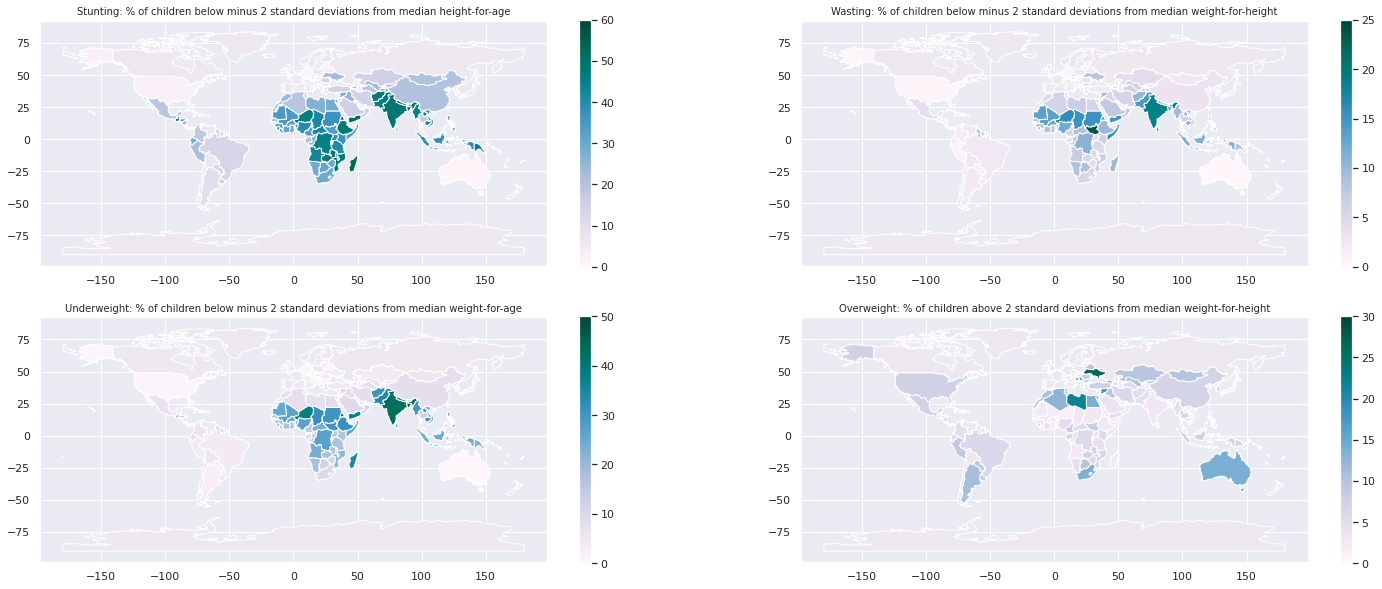

In [10]:
def plot_global_malnutrition(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and produces 4 plots on
    the same figure showing information about the malnutrition levels
    across the globe by visualizing the percent stunting, wasting,
    underweight, overweight of under five population in all
    the countries there is data for. Does not return anything.
    """

    merged = map_data("naturalearth_lowres", data)
    filtered = merged[["name", "Stunting", "Wasting", "Underweight",
                       "Overweight", "geometry"]]
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(25, 10))
    merged.plot(color="#ede8ed", ax=ax1)
    filtered.plot(column='Stunting', legend=True, ax=ax1,
                  vmin=0, vmax=60, cmap="PuBuGn")
    merged.plot(color="#ede8ed", ax=ax2)
    filtered.plot(column='Wasting', legend=True, ax=ax2,
                  vmin=0, vmax=25, cmap="PuBuGn")
    merged.plot(color="#ede8ed", ax=ax3)
    filtered.plot(column='Underweight', legend=True, ax=ax3,
                  vmin=0, vmax=50, cmap="PuBuGn")
    merged.plot(color="#ede8ed", ax=ax4)
    filtered.plot(column='Overweight', legend=True, ax=ax4,
                  vmin=0, vmax=30, cmap="PuBuGn")
    ax1.set_title(('Stunting: % of children below minus 2 standard deviations from median height-for-age'), fontsize=10)
    ax2.set_title(('Wasting: % of children below minus 2 standard deviations from median weight-for-height'), fontsize=10)
    ax3.set_title(('Underweight: % of children below minus 2 standard deviations from median weight-for-age'), fontsize=10)
    ax4.set_title(('Overweight: % of children above 2 standard deviations from median weight-for-height'), fontsize=10)


plot_global_malnutrition(filter_malnutrition_data('country-wise-average.csv'))

# Research Question #2
Which countries have the highest and lowest rates of malnutrition, and how do the costs of a healthy diet vary across these countries?

In [11]:
def plot_highest_overall(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph with Country
    as x-axis and Average percent as the y-axis. Visualizes the ten countries
    with the highest rates of average malnutrition. Does not return anything
    """

    top_avg_data = data.groupby("Country")["Average"].mean().nlargest(10).round()
    top_countries = top_avg_data.index
    fig = px.bar(data, x=top_countries, y=top_avg_data, color=top_countries,
                 color_discrete_sequence=px.colors.sequential.Blues)
    fig.update_layout(
        title="Top 10 Countries with Highest Malnutrition Rate Overall",
        xaxis_title="Country",
        yaxis_title="Average Malnutrition %"
    )
    fig.show()


def plot_lowest_overall(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph with Country
    as x-axis and Average percent as the y-axis. Visualizes the ten countries
    with the lowerst rates of average malnutrition. Does not return anything
    """

    top_avg_data = data.groupby("Country")["Average"].mean().nsmallest(10).round()
    top_countries = top_avg_data.index
    fig = px.bar(data, x=top_countries, y=top_avg_data, color=top_countries,
                 color_discrete_sequence=px.colors.sequential.Blues)
    fig.update_layout(
        title="Top 10 Countries with Lowest Malnutrition Rate Overall",
        xaxis_title="Country",
        yaxis_title="Average Malnutrition %"
    )
    fig.show()


def plot_lowest_cost(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph with Country
    as x-axis and Cost as the y-axis. Visualizes the ten countries with the
    lowest cost of a healthy diet. Does not return anything
    """

    data = data[["Income Classification", "Average",
                 "Cost of Healthy Diet",
                 "Percentage Unable to Afford", 'Country']]
    top_avg_data = data.groupby("Country")["Cost of Healthy Diet"].mean().nsmallest(10).round()
    top_countries = top_avg_data.index
    fig = px.bar(data, x=top_countries, y=top_avg_data, color=top_countries,
                 color_discrete_sequence=px.colors.sequential.Blues)
    fig.update_layout(
        title="Top 10 Countries with Lowest Cost of Healthy Diet",
        xaxis_title="Country",
        yaxis_title="Cost (dollar per person per day)"
    )
    fig.show()


def plot_highest_cost(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and plots a bar graph with Country
    as x-axis and Cost as the y-axis. Visualizes the ten countries with the
    highest cost of a healthy diet. Does not return anything
    """

    data = data.dropna()[["Income Classification", "Average",
                          "Cost of Healthy Diet",
                          "Percentage Unable to Afford", 'Country']]
    top_avg_data = data.groupby("Country")["Cost of Healthy Diet"].mean().nlargest(10).round()
    top_countries = top_avg_data.index
    fig = px.bar(data, x=top_countries, y=top_avg_data,
                 color=top_countries,
                 color_discrete_sequence=px.colors.sequential.Blues)
    fig.update_layout(
        title="Top 10 Countries with Highest Cost of Healthy Diet",
        xaxis_title="Country",
        yaxis_title="Cost (dollar per person per day)"
    )
    fig.show()


def plot_malnutrition_vs_affordability(data: pd.DataFrame) -> None:
    """
    This functions takes a pandas DataFrame and plots a scatter plot that
    visualizes the relationship between average malnutrition (x-axis)
    and the percentage of population unable to afford a healthy diet
    (y-axis) for each country. Does not return anything
    """

    data = data[["Income Classification", "Average",
                 "Cost of Healthy Diet",
                 "Percentage Unable to Afford", 'Country']]
    fig = px.scatter(data, x="Average",
                     y="Percentage Unable to Afford",
                     color="Country", title=("Percent Unable to Afford Diet vs Average Malnutrition Rate"),
                     trendline='ols')
    fig.update_layout(
        xaxis_title="Average Overall Malnutrition Rate",
        yaxis_title="Percentage of Population Unable to Afford Healthy Diet"
    )
    fig.show()


def plot_malnutrition_vs_cost(data: pd.DataFrame) -> None:
    """
    This functions takes a pandas DataFrame and plots a scatter plot that
    visualizes the relationship betweenh average malnutrition (x-axis)
    and the cost of a healthy diet per person per day (y-axis) for each
    country. Does not return anything.
    """

    data = data[["Income Classification", "Average",
                 "Cost of Healthy Diet",
                 "Percentage Unable to Afford", 'Country']]
    fig = px.scatter(data, x="Average", y="Cost of Healthy Diet",
                     color="Country",
                     title=("Cost of Healthy Diet vs Avg Malnutrition Rate"),
                     trendline='ols')
    fig.update_layout(
        xaxis_title="Average Overall Malnutrition Rate",
        yaxis_title="Cost of Healthy Diet Per Person Per day (PPP)"
    )
    fig.show()



# Research Question #3
Can we train an accurate model to predict the average malnutrition levels of a country based on data such as income classification, cost of healthy diet, and the percentage of population unable to afford a healthy diet? 

In [12]:
def predict_malnutrition(data: pd.DataFrame) -> None:
    """
    This function takes a pandas DataFrame and trains a
    DecisionTreeRegressor as well as a Multi Layer Perceptron to
    predict the average malnutrition for a given, Income Classification,
    Cost of Healthy Diet, percentage of population unable to afford healthy
    diet, percent underweight, overweight, stunting, and wasting. Prints the
    accuracy of the MLP, and the train and test MSE for both MLP and
    DecisionTreeRegressor, and plots dependence curves for Income
    Classification, Cost of Healthy Diet and Percent Unable to Afford
    """

    merged = data[["Income Classification", "Average",
                   "Cost of Healthy Diet",
                   "Percentage Unable to Afford",
                   "Underweight", "Overweight", "Stunting", "Wasting"]]
    features = merged.loc[:, merged.columns != "Average"]
    labels = merged["Average"]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                        labels,
                                                        test_size=0.20)

    # Train decision tree and a multi layer perceptron on the dataset
    model = DecisionTreeRegressor()
    mlp = make_pipeline(
        StandardScaler(),
        MLPRegressor(hidden_layer_sizes=(100, 100),
                     tol=1e-2, max_iter=500, random_state=0),
    )
    model.fit(X_train, y_train)
    mlp.fit(X_train, y_train)

    y_train_tree_pred = model.predict(X_train)
    y_test_tree_pred = model.predict(X_test)

    # Predict using the multi-layer perceptron classifier
    y_train_mlp_pred = mlp.predict(X_train)
    y_test_mlp_pred = mlp.predict(X_test)

    print(f"mean accuracy of mlp: {mlp.score(X_test, y_test):.2f}")

    print('Train MSE (Tree):', mean_squared_error(y_train, y_train_tree_pred))
    print('Test MSE (Tree):', mean_squared_error(y_test, y_test_tree_pred))

    print('Train MSE (MLP):', mean_squared_error(y_train, y_train_mlp_pred))
    print('Test MSE (MLP):', mean_squared_error(y_test, y_test_mlp_pred))

    X_train = X_train.astype(int)

    print()
    # Plot partial dependence curves for features for tree model
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Decision Tree", fontsize=15)
    tree_disp = PartialDependenceDisplay.from_estimator(model, X_train,
                                                        [("Income Classification"),
                                                         ("Cost of Healthy Diet"),
                                                         ("Percentage Unable to Afford")], ax=ax)

    # Plot partial dependence curves for features for mlp model
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_title("Multi-layer Perceptron", fontsize=15)
    mlp_disp = PartialDependenceDisplay.from_estimator(mlp, X_train,
                                                       [("Income Classification"),
                                                        ("Cost of Healthy Diet"),
                                                        ("Percentage Unable to Afford")],
                                                       ax=ax,
                                                       line_kw={"color": "red"})

# Testing

In [13]:
TOLERANCE = 0.001

def check_approx_equals(expected: Any, received: Any) -> bool:
    """
    Checks received against expected, and returns whether or
    not they match (True if they do, False otherwise).
    If the argument is a float, will do an approximate check.
    If the arugment is a data structure will do an approximate check
    on all of its contents.
    """
    try:
        if type(expected) == dict:
            # first check that keys match, then check that the
            # values approximately match
            return expected.keys() == received.keys() and \
                all([check_approx_equals(expected[k], received[k])
                    for k in expected.keys()])
        elif type(expected) == list or type(expected) == set:
            # Checks both lists/sets contain the same values
            return len(expected) == len(received) and \
                all([check_approx_equals(v1, v2)
                    for v1, v2 in zip(expected, received)])
        elif type(expected) == float:
            return math.isclose(expected, received, abs_tol=TOLERANCE)
        elif type(expected) == np.ndarray:
            return np.allclose(expected, received, abs_tol=TOLERANCE,
                               equal_nan=True)
        elif type(expected) == pd.DataFrame:
            try:
                pd.testing.assert_frame_equal(expected, received,
                                              atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        elif type(expected) == pd.Series:
            try:
                pd.testing.assert_series_equal(expected, received,
                                               atol=TOLERANCE)
                return True
            except AssertionError:
                return False
        else:
            return expected == received
    except Exception as e:
        print(f"EXCEPTION: Raised when checking check_approx_equals {e}")
        return False


def assert_equals(expected: Any, received: Any) -> None:
    """
    Checks received against expected, throws an AssertionError
    if they don't match. If the argument is a float, will do an approximate
    check. If the arugment is a data structure will do an approximate check
    on all of its contents.
    """

    if type(expected) == str:
        # Make sure strings have explicit quotes around them
        err_msg = f'Failed: Expected "{expected}", but received "{received}"'
    elif type(expected) in [np.ndarray, pd.Series, pd.DataFrame]:
        # Want to make multi-line output for data structures
        err_msg = f'Failed: Expected\n{expected}\n\nbut received\n{received}'
    else:
        err_msg = f'Failed: Expected {expected}, but received {received}'

    assert check_approx_equals(expected, received), err_msg

In [14]:
def test_filter_malnutrition() -> None:
    """
    Tests the filter_malnutrition method, specifically the added average column
    """
    data = filter_malnutrition_data("/content/country-wise-average.csv")
    check_approx_equals(57.793, data["Average"].loc[:0].item())


def test_map_data() -> None:
    """
    Tests the map_data method, specifically the merged data column
    """
    data = filter_malnutrition_data("/content/country-wise-average.csv")
    assert_equals(177, len(map_data("naturalearth_lowres", data)))


def test_filter_cost_data() -> None:
    """
    Tests the filter_cost_data method, specifically the merged data column
    """
    data = filter_cost_data("/content/Cost_Affordability_Healthy_Diet_Data.csv")
    # assert_equals(220, len(data))


def main():
    test_filter_malnutrition()
    test_map_data()
    test_filter_cost_data

if __name__ == '__main__':
    main()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Client


mean accuracy of mlp: 0.97
Train MSE (Tree): 0.0
Test MSE (Tree): 24.613144284041134
Train MSE (MLP): 2.3182278597230006
Test MSE (MLP): 6.591727323048819



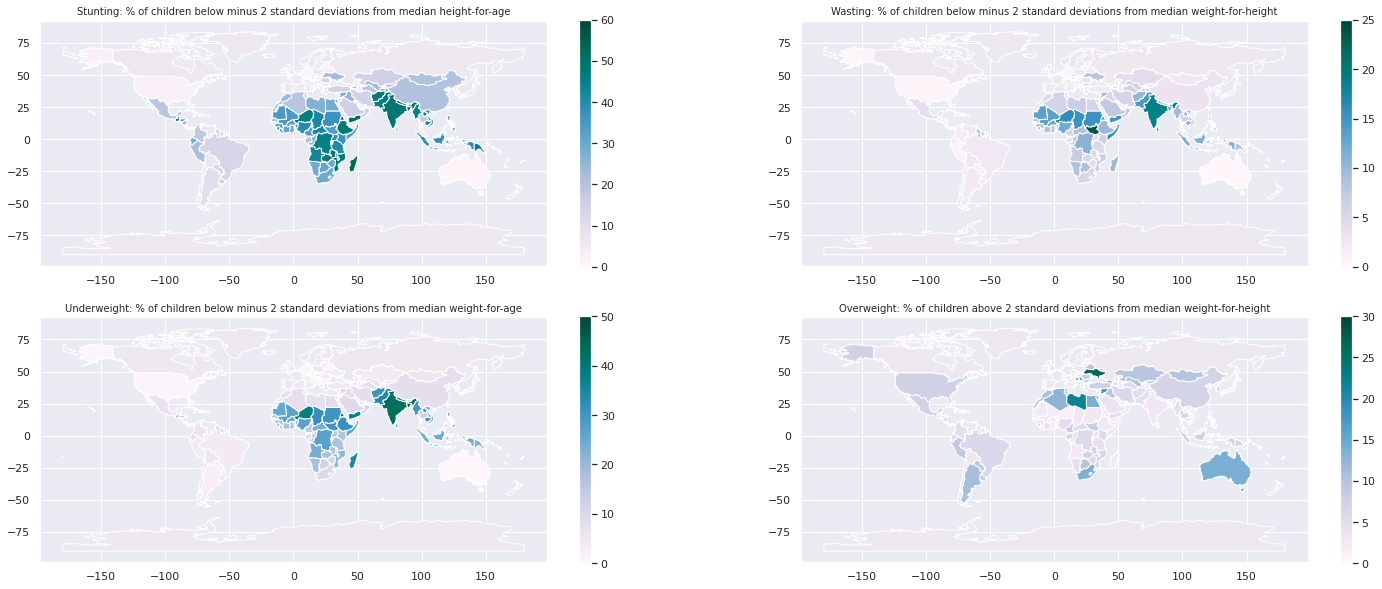

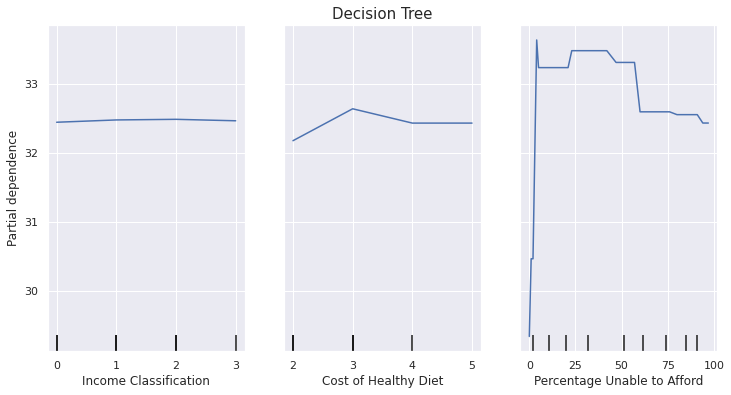

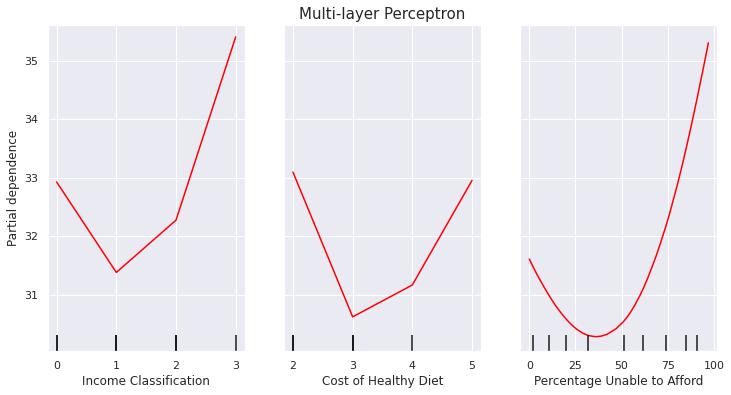

In [15]:
def main():
    malnutrition_data = filter_malnutrition_data('country-wise-average.csv')
    cost_data = filter_cost_data('Cost_Affordability_Healthy_Diet_Data.csv')
    merged_data = merge_cost_and_malnutrition(cost_data, malnutrition_data)

    plot_top_ten_stunting(malnutrition_data)
    plot_top_wasting(malnutrition_data)
    plot_top_underweight(malnutrition_data)
    plot_top_overweight(malnutrition_data)
    plot_global_malnutrition(malnutrition_data)

    print()
    plot_highest_overall(malnutrition_data)
    plot_lowest_overall(malnutrition_data)
    plot_lowest_cost(merged_data)
    plot_highest_cost(merged_data)
    plot_malnutrition_vs_affordability(merged_data)
    plot_malnutrition_vs_cost(merged_data)

    print()
    predict_malnutrition(merged_data)

if __name__ == '__main__':
    main()